In [ ]:
!wget https://raw.githubusercontent.com/teavanist/MNIST-JPG/master/MNIST%20Dataset%20JPG%20format.zip

--2024-11-10 08:47:49--  https://raw.githubusercontent.com/teavanist/MNIST-JPG/master/MNIST%20Dataset%20JPG%20format.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52766564 (50M) [application/zip]
Saving to: ‘MNIST Dataset JPG format.zip’

MNIST Dataset JPG f 100%[===================>]  50.32M   260MB/s    in 0.2s    

2024-11-10 08:47:49 (260 MB/s) - ‘MNIST Dataset JPG format.zip’ saved [52766564/52766564]



In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 32.5 MB/s eta 0:00:00


In [ ]:
!unzip 'MNIST Dataset JPG format.zip'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/1820.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18211.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18228.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18241.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18251.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/1826.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18277.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18296.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/183.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18350.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18355.jpg  
 extracting: MNIST Dataset JPG format/MNIST - JPG - training/9/18374.jpg  
 extracting: MNIST Dataset JPG format/MNIST - J

In [ ]:
ls

'MNIST Dataset JPG format'/  'MNIST Dataset JPG format.zip'   sample_data/


In [ ]:
from glob import glob  # For file path matching and retrieval
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations on arrays
import os  # For operating system interface
import lightning as L  # For PyTorch Lightning functionality
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping  # Model callbacks
import torchmetrics  # For PyTorch metrics computation
import torch  # For PyTorch deep learning framework
from torch import nn  # For building neural network modules
import torchvision  # For computer vision utilities and datasets
from torchvision import transforms  # For data transformations
import torchvision.transforms.functional as F  # Functional transformations
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.model_selection import train_test_split  # For data splitting
import random  # For random number generation
from lightning.pytorch.callbacks import ModelSummary  # For summarizing model architecture

def set_seed(seed: int = 0) -> None:
    """Set random seed for reproducibility across numpy, random, torch, and CUDA."""
    np.random.seed(seed)  # Seed for numpy operations
    random.seed(seed)  # Seed for random module
    torch.manual_seed(seed)  # Seed for PyTorch on CPU
    torch.cuda.manual_seed(seed)  # Seed for PyTorch on CUDA GPU

    # Ensure reproducibility on CuDNN backend
    torch.backends.cudnn.deterministic = True  # Disable nondeterministic algorithms
    torch.backends.cudnn.benchmark = False  # Disable performance optimizations for determinism

    # Set a fixed value for the hash seed for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")  # Confirm seed setting

# Set default seed for reproducibility
set_seed()


Random seed set as 0


In [ ]:
val_path = "./MNIST Dataset JPG format/MNIST - JPG - testing/"  # Path to validation dataset
train_path = "./MNIST Dataset JPG format/MNIST - JPG - training/"  # Path to training dataset

# List all file or directory names in the training path directory
list_ = [name for name in os.listdir(train_path)]

def get_path(path):
    """Generate a list of dictionaries with image paths, labels, and class names for a given dataset path."""
    paths = []
    for name in list_:
        # Retrieve all .jpg files within each subdirectory under the given path
        l = glob(f"{path}{name}/*.jpg")

        # Append each image's path and its label (converted to int) to the paths list
        for i in l:
            paths.append({
                "name": name,
                "path": i,
                "label": int(name)
            })

    return paths

# Generate lists of paths with labels for both training and validation datasets
train_paths = get_path(train_path)
val_paths = get_path(val_path)


In [ ]:
class DataSet(torch.utils.data.Dataset):
    """Custom Dataset for loading images and their corresponding labels."""

    def __init__(self, features, transform=None):
        """Initialize the dataset with features and optional transformations.

        Args:
            features (list): List of dictionaries containing image paths and labels.
            transform (callable, optional): Optional transform to be applied on the images.
        """
        super(DataSet, self).__init__()
        self.features = features  # Store the list of features (paths and labels)
        self.transform = transform  # Store the transformation if provided

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.features)

    def __getitem__(self, idx):
        """Retrieve an item from the dataset given an index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the image tensor and its corresponding label.
        """
        # Get the path of the image based on the index
        paths = self.features[idx]["path"]

        # Read the image from the path
        images = torchvision.io.read_image(paths)

        # Convert grayscale image to 3 channels by stacking
        images = torch.stack([images[0], images[0], images[0]], 0)

        # Apply transformations if any
        if self.transform is not None:
            images = self.transform(images)

        # Retrieve the label for the current index
        label = torch.tensor(self.features[idx]["label"])

        return {"images": images, "labels": label}

# Instantiate the dataset with training paths
Data = DataSet(train_paths)


In [ ]:
next(iter(Data))["images"].shape

torch.Size([3, 28, 28])

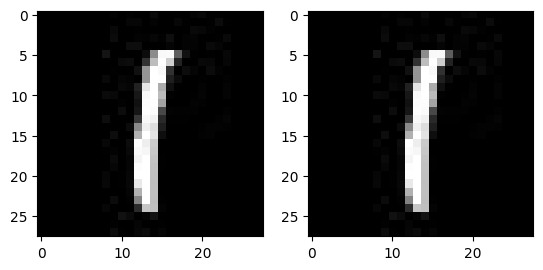

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))

show([next(iter(Data))["images"], next(iter(Data))["images"]])

In [ ]:
class DataModule(L.LightningDataModule):
    def __init__(self, batch_size, num_workers, train_path, val_path):
        super(DataModule, self).__init__()
        self.train_path = train_path
        self.val_path = val_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        # Tạo một danh sách các phép biến đổi bạn muốn áp dụng trong compose


# Tạo compose từ danh sách phép biến đổi
        self.train_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

            ]
        )

        self.test_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ]
        )

    def setup(self, stage=None):
        train_paths = get_path(self.train_path)
        val_paths = get_path(self.val_path)
        train_paths, test_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

        self.train_dataset = DataSet(train_paths, transform=self.train_transforms)  # Áp dụng data_transforms trong DataSet
        self.val_dataset = DataSet(val_paths, transform=self.test_transforms)
        self.test_dataset = DataSet(test_paths, transform=self.test_transforms)


    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, shuffle=True,
                                           batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, shuffle=False,
                                           batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, shuffle=False,
                                           batch_size=self.batch_size, num_workers=self.num_workers)

data_module = DataModule(8, 2, train_path, val_path)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [ ]:
next(iter(train_loader))["images"].shape

torch.Size([8, 3, 224, 224])

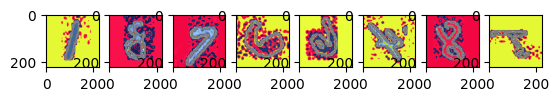

In [ ]:
images = [image for image in next(iter(train_loader))["images"]]
show(images)

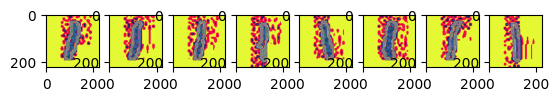

In [ ]:
images = [image for image in next(iter(val_loader))["images"]]
show(images)

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)


# Define a LightningModule using the custom VGG16
class CustomVGG16(L.LightningModule):
    def __init__(self, num_classes=10, lr=1e-4):
        super(CustomVGG16, self).__init__()
        self.model = VGG16(num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

#### **1. Train lại model trên bằng toàn bộ dataset vơi 5 epochs**

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = CustomVGG16()

data_module = DataModule(128, 2, train_path, val_path)
trainer = L.Trainer(max_epochs=5, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, data_module)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.96830 (best 0.96830), saving model to '/content/checkpoint/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.96830 (best 0.96830), saving model to '/content/checkpoint/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.98290 (best 0.98290), saving model to '/content/checkpoint/epoch=1-step=750.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.98290 (best 0.98290), saving model to '/content/checkpoint/epoch=1-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1125: 'val_acc' reached 0.98520 (best 0.98520), saving model to '/content/checkpoint/epoch=2-step=1125.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1125: 'val_acc' reached 0.98520 (best 0.98520), saving model to '/content/checkpoint/epoch=2-step=1125.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1500: 'val_acc' reached 0.98740 (best 0.98740), saving model to '/content/checkpoint/epoch=3-step=1500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1500: 'val_acc' reached 0.98740 (best 0.98740), saving model to '/content/checkpoint/epoch=3-step=1500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1875: 'val_acc' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1875: 'val_acc' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.98458331823349      │
│         test_loss         │    0.05735616385936737    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.05735616385936737, 'test_acc': 0.98458331823349}]

In [ ]:
data_module = DataModule(64, 8, train_path, val_path)
data_module.setup()
#train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = CustomVGG16.load_from_checkpoint("/content/checkpoint/epoch=3-step=1500.ckpt")
predictions_ = trainer.predict(model, test_loader)
all_max_indices = torch.tensor([])
for i in predictions_:
    all_max_indices = torch.concat([all_max_indices, i['y_pred']])

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
all_max_indices

tensor([1., 7., 3.,  ..., 8., 7., 5.])

#### **2. Hãy train model VGG-C, và VGG-E và so sánh các kết quả trên tập test**

###### **Model VGG-C và Đánh gái mô hình trên tập test**

In [ ]:
class VGG_C(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG_C, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)
class CustomVGG_C(L.LightningModule):
    def __init__(self, num_classes=10, lr=1e-4):
        super(CustomVGG_C, self).__init__()
        self.model = VGG_C(num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [ ]:
model_VGGC_checkpoint = ModelCheckpoint(dirpath='checkpoint/VGG_C/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_VGGC_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = CustomVGG_C()

data_module = DataModule(128, 2, train_path, val_path)
trainer = L.Trainer(max_epochs=2, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, data_module)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.93010 (best 0.93010), saving model to '/content/checkpoint/VGG_C/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.93010 (best 0.93010), saving model to '/content/checkpoint/VGG_C/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.97680 (best 0.97680), saving model to '/content/checkpoint/VGG_C/epoch=1-step=750.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.97680 (best 0.97680), saving model to '/content/checkpoint/VGG_C/epoch=1-step=750.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9767500162124634     │
│         test_loss         │    0.07702405005693436    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07702405005693436, 'test_acc': 0.9767500162124634}]

###### **Model VGG-E và Đánh giá mô hình trên tập test**

In [ ]:
class VGG_E(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG_E, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        vgg_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

        for v in vgg_config:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v

        return nn.Sequential(*layers)
class CustomVGG_E(L.LightningModule):
    def __init__(self, num_classes=10, lr=1e-4):
        super(CustomVGG_E, self).__init__()
        self.model = VGG_E(num_classes)
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


In [ ]:
model_VGGE_checkpoint = ModelCheckpoint(dirpath='checkpoint/VGG_E/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_VGGE_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = CustomVGG_E()

data_module = DataModule(128, 2, train_path, val_path)
trainer = L.Trainer(max_epochs=2, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, data_module)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 375: 'val_acc' reached 0.95400 (best 0.95400), saving model to '/content/checkpoint/VGG_E/epoch=0-step=375.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 375: 'val_acc' reached 0.95400 (best 0.95400), saving model to '/content/checkpoint/VGG_E/epoch=0-step=375.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 750: 'val_acc' reached 0.97970 (best 0.97970), saving model to '/content/checkpoint/VGG_E/epoch=1-step=750.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 750: 'val_acc' reached 0.97970 (best 0.97970), saving model to '/content/checkpoint/VGG_E/epoch=1-step=750.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
trainer.test(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9782500267028809     │
│         test_loss         │    0.07212074100971222    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07212074100971222, 'test_acc': 0.9782500267028809}]